# TensorFlow RNN tutorial

Moving from matlab to python: http://www.justinkiggins.com/blog/moving-from-matlab-to-python/
- Use Anaconda as a python distribution.
- Use Jupyter notebook (comes with anaconda) for anything you would do with cell mode scripts or the command line in matlab.
- Use a good text editor (sublime text 3 or atom) for editing/viewing python functions.

---

Learning numpy: http://cs231n.github.io/python-numpy-tutorial/

---

Learning matplotlib: http://www.labri.fr/perso/nrougier/teaching/matplotlib/

---

Caffe, Torch, Theano, TensorFlow -- which to use: http://cs231n.stanford.edu/slides/winter1516_lecture12.pdf
- Use Theano or TensorFlow for RNNs
- Theano is better now, but TensorFlow might be better in the future (academic vs industry projects, blah blah)

Perhaps consider frameworks that sit on top of Theano or TensorFlow:
- Keras
- Blocks
- so many others...

---

My current favorite TensorFlow tutorial: http://cs224d.stanford.edu/lectures/CS224d-Lecture7.pdf

# 1 Hello world

In [1]:
import tensorflow as tf

In [2]:
hello = tf.constant('TensorFlow helps the tensors flow.')

In [3]:
sess = tf.Session() # What is a session?

In [4]:
print sess.run(hello) # Why sess.run()? 
sess.close()

TensorFlow helps the tensors flow.


# 2 Linear regression
Essentially from http://cs224d.stanford.edu/lectures/CS224d-Lecture7.pdf

In [5]:
%reset -f
%matplotlib inline

In [6]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn
tf.reset_default_graph()

In [7]:
# Model parameters
slope = 0.5
bias = 2
sigma = 0.5

# Data
n_samples = 1000
batch_size = 100

# Generate data
x_data = 10*np.random.random(n_samples) - 5
y_data = slope * x_data + bias + sigma*np.random.randn(n_samples)

# Reshape: size (n_samples,) to size (n_samples,1)
x_data = np.reshape(x_data, (n_samples,1))
y_data = np.reshape(y_data, (n_samples,1))

# Define tf placeholders
X = tf.placeholder(tf.float32, shape=(batch_size, 1))
Y = tf.placeholder(tf.float32, shape=(batch_size, 1))

In [8]:
# Model
with tf.variable_scope("linear-regression"):    
    W = tf.get_variable("weights", (1,1), initializer = tf.random_normal_initializer())
    b = tf.get_variable("bias", (1,), initializer = tf.constant_initializer(0.0))
    y_hat = tf.matmul(X,W) + b
    loss = tf.reduce_sum((Y - y_hat)**2/n_samples)

In [9]:
opt = tf.train.GradientDescentOptimizer(learning_rate = 0.1)
opt_operation = opt.minimize(loss)

Iter: 0000 Loss: 1.5973
Iter: 0100 Loss: 0.0289
Iter: 0200 Loss: 0.0246
Iter: 0300 Loss: 0.0240
Iter: 0400 Loss: 0.0240
Iter: 0500 Loss: 0.0241
Iter: 0600 Loss: 0.0299
Iter: 0700 Loss: 0.0295
Iter: 0800 Loss: 0.0252
Iter: 0900 Loss: 0.0225


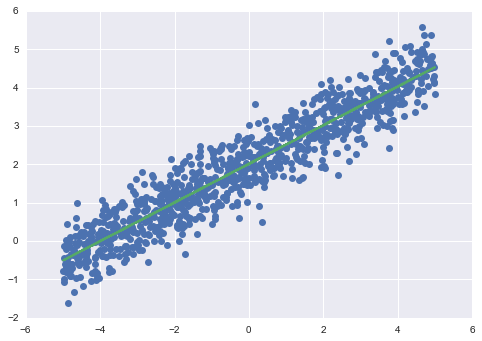

In [10]:
with tf.Session() as sess:    
    # Initialize variables
    sess.run(tf.initialize_all_variables())

    # Gradient descent for _ steps
    for i in range(1000):
        # Select random minibatch
        indices = np.random.choice(n_samples, batch_size)
        x_batch, y_batch = x_data[indices], y_data[indices]
        _, loss_val = sess.run([opt_operation, loss], feed_dict={X: x_batch, Y: y_batch})
        
        if i % 100 == 0:
            print "Iter:", "%04d" % (i), \
                  "Loss:", "{:.4f}".format(loss_val)

    # Plotting
    plt.plot(x_data, y_data,'o')
    plt.plot(x_data, x_data * sess.run(W) + sess.run(b))    
    plt.show()

# 3 RNNs

In [145]:
%reset -f
%matplotlib inline

In [146]:
import tensorflow as tf
from tensorflow.models.rnn import rnn

import numpy as np
import matplotlib.pyplot as plt
from scipy import signal # For constructing fun signals.
import seaborn as sns # Pretty plots.

Note: You do not need `rnn` and `rnn_cell` from `tensorflow.models.rnn` in order to implement RNNs using TensorFlow. These modules are useful abstractions, but you can also implement RNNs 'by hand'. It is worth reading the `rnn.py` and `rnn_cell.py` files (on a Mac, just spotlight search for them; they are on your computer).

In short, `rnn.py` essentially takes the "cell" specified by `rnn_cell.py` and creates the computational graph by unrolling in time.

### Create input and output data:

Many RNN tutorials start with very difficult or specialized problems where the signals live in exotic spaces. The official introductory RNN tutorial for TensorFlow uses an LSTM for natural language processing. Yikes.

For this tutorial, we will work with simple signals, an input $u(t)\in\mathbb{R}^m$ and an output $y(t)\in\mathbb{R}^p$, usually simple sinusoids, square waves, etc, in discrete time, and for $T$ time steps. As matrices, we have our dataset: $U\in\mathbb{R}^{T\times m}$ and $Y\in\mathbb{R}^{T\times p}$.

We will eventually need to split signals into smaller sized-batches of size $T_{\text{batch}}\times m$. Thus, a 'training example' will be a subsequence of the full, length-$T$ dataset. Some datasets are naturally split into different 'batches'. Here we will consider one length-$T$ dataset without loss of intuition.

In [147]:
# Signal parameters
cycle = 100 # cycle length
T = 10*cycle # total time
t = np.arange(T)

In [148]:
def rand_signal(time_, cycle_, components_):
    """ 
    Create a size (T,) signal with lognormal distribution of component frequencies.
    """
    freq = 2*np.pi/cycle_*np.random.lognormal(mean=0, size=components_)
    phi = np.random.rand(components_)*cycle_
    z = np.sin(np.outer(time_, freq) + phi)
    z = z.sum(axis=1) # add up the sinusoids 
    z = (z - z.min()) / (z.max() - z.min()) # normalize
    z = 2*z - 1 # set range to [-1,1]
    return z

In [149]:
# Create different signals to play with
# Each signal set, z_*, will be size (T,n_sig)
n_sig = 10 
freq = 2*np.pi/cycle*np.linspace(1,5,n_sig)

# ∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿
phi = np.random.rand(n_sig)*cycle
z_sin = np.sin(np.outer(t,freq) + phi)

# ◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻
phi = np.random.rand(n_sig)*cycle
z_square = signal.square(np.outer(t,freq) + phi)

# |/|/|/|/|/|/|/|/|/|/|/|/|/|/|/|/|/|/|/|/|/|
phi = np.random.rand(n_sig)*cycle
z_saw = signal.sawtooth(np.outer(t,freq) + phi)

# ◻∿◻∿◻∿◻∿◻∿◻∿◻∿◻∿◻∿◻∿◻∿◻∿◻∿◻∿◻∿◻∿◻∿◻
freq = 2*np.pi/cycle*np.linspace(5,20,n_sig)
phi = np.random.rand(n_sig)*cycle
z_modsq = signal.square(np.outer(freq,t) + phi.reshape([-1,1]),
                        duty=(0.5*np.sin(2*np.pi/cycle* 1 *t)+0.5))
z_modsq = z_modsq.T

# @.^;{&(*[\"@@{£*|'}{('£?}@*+.#~=@*+^%[&_
z_psrnd = 2*np.round(np.random.rand(T,n_sig))-1

# ∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿∿
z_randsin = np.zeros((T,n_sig))
for i in range(n_sig):
    z_randsin[:,i] = rand_signal(t, cycle, 10)

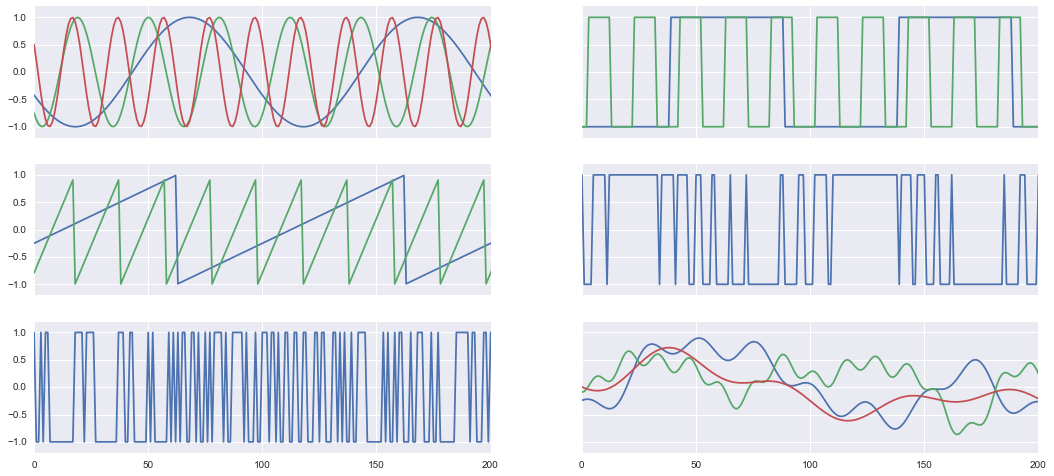

In [164]:
# Plot signals
f, ((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3,2,sharex='col',sharey='row', figsize=(18,8),
                                        subplot_kw=dict(xlim=(0,2*cycle),
                                                        ylim=(-1.2,1.2)))
ax1.plot(z_sin[:,[0,5,9]])
ax2.plot(z_square[:,[0,9]])
ax3.plot(z_saw[:,[0,9]])
ax4.plot(z_modsq[:,[5]])
ax5.plot(z_psrnd[:,[0]])
ax6.plot(z_randsin[:,[0,1,2]])
plt.show()

### RNNs:
Our goal is to fit a function, called a (dynamical) system, $F:U\rightarrow Y$, where $U\in\mathbb{R}^{T\times m}$ and $Y\in\mathbb{R}^{T\times p}$. Generally, the output may depend on inputs from time steps far away. E.g. we might have $y(t)$ depend somehow on $u(t-10)$. RNNs -- more generally, state-space models -- replace all higher-order dependencies with first-order dependencies via a standard mathematical trick: introduce a new, possibly high-dimensional, latent variable $x$. The rough intuition from linear systems is that if there is a 10th-order dependence in your system, you need $x$ to be at least 10-dimensional. As a bonus, state-space models give a realization of $F$ that is causal (nowhere do variables explicitly depend on the future).

The term "order" is used in the preceding paragraph because the shift operator $\sigma x(t) = x(t+1)$ can be thought of as a discrete-time analog of a derivative and $\sigma^{10}x(t)$ would be a "10th order" term in a model.

An RNN is:

$$
\begin{align}
    x(t+1) &= f(Ax(t) + Bu(t) + b) \\
    y(t) &= Cx(t) + c
\end{align}
$$

with $u\in\mathbb{R}^m$, $x\in\mathbb{R}^n$, $y\in\mathbb{R}^p$, and $t=0,\dots\,T-1$

Here, $u$, $y$, $f$ are all known, and we estimate $A$, $B$, $b$, $C$, $c$. We also estimate $x(0)$, which for deterministic systems (like the one written above) uniquely determines $x(t)$ for all $t$. For stochastic systems we need to be careful about the interaction of the system itself and its state sequence. Proper estimation of $x$ requires filtering. (Kalman) filtering can be used in the model validation step, and for some types of problems will be very important.

It is entirely possible to just fit $F$ directly without introducing a latent variable. Look at the NARMAX literature, for example.

[maybe write both versions of RNNs]

#### Some TensorFlow RNN basics:
* A *batch* is a size $T_\text{batch}\times n$ signal.
* Standard: use the variable name `num_steps` to refer to $T_\text{batch}$.
* Standard: use the variable name `batch_size` to refer to the number of batches that are optimized over in parallel in one optimization step.

Suppose we had one long $U\in\mathbb{R}^{T\times m}$ input signal and one $Y\in\mathbb{R}^{T\times p}$ output signal. Let us consider four strategies for fitting the function $F:U\rightarrow Y$ using RNNs. Suppose `T=100`.

#### Batch strategies:

1. Set `num_steps=100` and `batch_size=1`.
2. Set `num_steps=20` and `batch_size=5` and split the batches evenly.    
3. Set, say, `num_steps=10` and `batch_size=5`, and let each batch be randomly chosen (one new batch selection per optimization step).
4. Set, say, `num_steps=10` and `batch_size=T-num_steps=90`, and consider every possible batch.

Strategy 1 is standard BPTT. Have to estimate x(0)

Strategy 2: Batch 1 is `t=0` to `t=19`, batch 2 is `t=20` to `t=39`, etc. At each optimization step we use the same 5 batches. The optimization never tries to fit the transition from `t=19` to `t=20` for example. As a consequence of this strategy, we also esimate the state variable at times `t=0,20,40,..`. These are our initial states, one per batch.
    
Strategy 3 is SGD. Randomly choose 5 initial time points ranging from `0` to `T-num_steps` to specify 5 batches. There will likely be some overlapping batches. For one optimization step, esimate the corresponding initial states. For the next optimization step, we select a different set of 5 batches and estimate their corresponding initial states. After enough steps, we may have estimates for each initial state, thus giving us an estimate of the entire state sequence. A better approach to estimating the state sequence is to do a forward pass (good) or a Kalman filter (better).

Strategy 4 should evoke feelings related to block Hankel matrices and is, loosely speaking, the general strategy for linear system identification. For linear systems, this strategy requires `num_steps>=n`, the (a priori unknown) minimal state dimension.

We will use strategy 3.

In [151]:
# Some batch-related functions
def hankelize(a, num_steps_):
    """
    Convert size (T,n) matrix to size (num_steps, T-num_steps, n) tensor.
    Different batches can now be selected by a[:,batch_inds,:].
    Hankelize is not the correct term.
    """
    dims = a.shape
    T_new = dims[0] - num_steps
    b = np.zeros((T_new, num_steps, dims[1]))
    for i in range(T_new):
        b[i,:,:] = a[i:i+num_steps, :]
    b = np.transpose(b, (1,0,2)) # 
    return b

def get_rand_batch(a, batch_size_):
    """
    args: 
        a: size (num_steps, T_new, n) array
        batch_size: how many batches to select
    return:
        inds: indices for initial states of each batch
        a: size (num_steps, batch_size, n) array
    """
    inds = np.random.choice(T_new, batch_size)
    for i in range(len(a)):
        a[i] = a[i][:,inds,:] 
    return inds, a

In [250]:
# RNN dimensions
m = 4 # input dimension
n = 100 # state dimension
p = 4 # output dimension

# Time and batch parameters
num_steps = 30 
batch_size = 100
T_new = T - num_steps

In [251]:
# Choose our input and output data
u_data = z_sin[:,[0,2,6,9]]
y_data = np.concatenate((z_modsq[:,[0,9]], z_randsin[:,[0,1]]), axis=1)

u_data_h = hankelize(u_data, num_steps) # size (num_steps, T-num_steps, m)
y_data_h = hankelize(y_data, num_steps) # size (num_steps, T-num_steps, p)

### TensorFlow's basic RNN usage:

---
```python
import tensorflow as tf
from tensorflow.models.rnn import rnn

...

cell = tf.nn.rnn_cell.BasicRNNCell(n) # Other options include BasicLSTMCell, GRUCell, ...
outputs, state = rnn.rnn(cell, input_sequences, initial_state=x0) # or tf.models.rnn.rnn() w/o import
```
---


* `n` is the state dimension


* `input_sequences` is a python *list*. Each entry of this list is a TF tensor of shape `(batch_size,m)` where `m` is the dimension of the input. The length of this list is `num_step`.


* `initial_state=` takes an input (here, `x0`) of shape `(batch_size,n)` and is self-explanatory.


* `BasicRNNCell`  impelements: `output = new_state = tanh(A * state + input).`


* For `BasicRNNCell`, note that `new_state` (that is, $x(t+1)$) is the same as `output`. Thus to get $y(t)$ we wave to implement `output = C * state + c` ourselves. I think LSTM's have different `output` and `state` specifications.


* Additionally, we will have to implement `input = B * ext_input + b` where `ext_input` is $u(t)$


* It is possible to write code that can handle different `batch_size` values. [See here](https://www.tensorflow.org/versions/r0.8/resources/faq.html#tensor-shapes).

---

`rnn.rnn` does the unrolling in time so you don't have to. Here is a code snippet from `ptb_word_lm.py` -- TF's official RNN tutorial -- showing how you might unroll in time by hand:

```python
outputs = []
state = self._initial_state
with tf.variable_scope("RNN"):
  for time_step in range(num_steps):
    if time_step > 0: tf.get_variable_scope().reuse_variables() # .reuse_variables() is a key step here
    (cell_output, state) = cell(inputs[:, time_step, :], state)
    outputs.append(cell_output)

output = tf.reshape(tf.concat(1, outputs), [-1, size])
softmax_w = tf.get_variable("softmax_w", [size, vocab_size])
softmax_b = tf.get_variable("softmax_b", [vocab_size])
logits = tf.matmul(output, softmax_w) + softmax_b
loss = tf.nn.seq2seq.sequence_loss_by_example(
    [logits],
    [tf.reshape(self._targets, [-1])],
    [tf.ones([batch_size * num_steps])])
self._cost = cost = tf.reduce_sum(loss) / batch_size
self._final_state = state
```

In [252]:
tf.reset_default_graph() # It is sometimes good to reset_default_graph(), especially when working in notebooks

# Input Placeholders
U = tf.placeholder("float", [num_steps, batch_size, m])
Y = tf.placeholder("float", [num_steps, batch_size, p])
Inds = tf.placeholder(tf.int32, [batch_size,]) # The time point indices corresponding to initial states of the batches

# State sequence
x = tf.Variable(tf.zeros([T,n]), name="state")

# parameters
weights = {
    'B': tf.Variable(tf.random_normal([m,n]), name="B"), # B^T
    'C': tf.Variable(tf.random_normal([n,p]), name="C")  # C^T
} # note that we don't have 'A' -- this is because 'A' will be implemented when we call rnn_cell()
biases = {
    'b': tf.Variable(tf.random_normal([1,n]), name="b"), # b^T
    'c': tf.Variable(tf.random_normal([1,p]), name="c")  # c^T
}

In [253]:
# U is size (num_steps, batch_size, m), and rnn.rnn() requires we input a python list of length num_steps.
# Each entry of the list is a (batch_size,m) matrix.
# The tf.split function will handle this conversion:
Ul = [tf.squeeze(u_, [0]) for u_ in tf.split(0, num_steps, U)] # Ul stands for "U list"
Yl = [tf.squeeze(y_, [0]) for y_ in tf.split(0, num_steps, Y)]

In [254]:
# input = B*u + b
Ul = [tf.matmul(Ul[i], weights['B']) + biases['b'] for i in range(num_steps)]

In [255]:
# Create an RNN cell (a 'layer' of the unrolled graph)
# Create the unrolled graph with rnn.rnn()
with tf.variable_scope("RNN"):
    cell = tf.nn.rnn_cell.BasicRNNCell(n)
    outputs, state = rnn.rnn(cell, Ul, initial_state=tf.gather(x, Inds))

In [256]:
# output = C*y + c
y_hat = [tf.matmul(outputs[i], weights['C']) + biases['c'] for i in range(num_steps)]

In [257]:
# Model validation / analysis
# Create an RNN that spans all times. We will not backprop over this RNN, but we will use it for forward passes.
u_full = tf.placeholder("float",[T,m])

u_full_l = [u_ for u_ in tf.split(0, T, u_full)] # fix this?
u_full_l = [tf.matmul(u_full_l[i], weights['B']) + biases['b'] for i in range(T)]

with tf.variable_scope("RNN", reuse=True):
    out_full, state_full = rnn.rnn(cell, u_full_l, initial_state=tf.gather(x, tf.ones([1], dtype=tf.int32)))

x_hat_full = tf.concat(0,out_full)
y_hat_full = [tf.matmul(out_full[i], weights['C']) + biases['c'] for i in range(T)]
y_hat_full = tf.concat(0,y_hat_full)

with tf.variable_scope("RNN/RNN/BasicRNNCell/Linear", reuse=True):
    A = tf.get_variable("Matrix")

In [258]:
# specify the cost function, the optimization routine, and the optimization operator (minimization)
cost = tf.reduce_mean((tf.concat(0,y_hat) - tf.concat(0,Yl))**2) # L_2 minimization
opt = tf.train.AdamOptimizer(learning_rate = 0.01)
opt_op = opt.minimize(cost)

In [259]:
# Train the network
sess = tf.Session()
sess.run(tf.initialize_all_variables())

fig = plt.figure()

for i in range(10000):
    # select random minibatch
    inds_batch, [u_batch, y_batch] = get_rand_batch([u_data_h, y_data_h], batch_size)
    _, loss_val = sess.run([opt_op, cost], feed_dict={U: u_batch, Y: y_batch, Inds: inds_batch})
    if i % 100 == 0:
        print "Iter:", "%04d" % (i), \
              "Loss:", "{:.4f}".format(loss_val)

Iter: 0000 Loss: 47.9055
Iter: 0100 Loss: 0.4295
Iter: 0200 Loss: 0.2483
Iter: 0300 Loss: 0.1941
Iter: 0400 Loss: 0.1565
Iter: 0500 Loss: 0.1339
Iter: 0600 Loss: 0.1105
Iter: 0700 Loss: 0.1032
Iter: 0800 Loss: 0.0881
Iter: 0900 Loss: 0.0764
Iter: 1000 Loss: 0.0782
Iter: 1100 Loss: 0.0666
Iter: 1200 Loss: 0.0709
Iter: 1300 Loss: 0.0560
Iter: 1400 Loss: 0.0700
Iter: 1500 Loss: 0.0554
Iter: 1600 Loss: 0.0782
Iter: 1700 Loss: 0.0500
Iter: 1800 Loss: 0.0932
Iter: 1900 Loss: 0.0477
Iter: 2000 Loss: 0.0422
Iter: 2100 Loss: 0.0525
Iter: 2200 Loss: 0.0425
Iter: 2300 Loss: 0.0448
Iter: 2400 Loss: 0.0513
Iter: 2500 Loss: 0.0323
Iter: 2600 Loss: 0.0436
Iter: 2700 Loss: 0.0427
Iter: 2800 Loss: 0.0428


KeyboardInterrupt: 

In [260]:
y_predicted, x_predicted, A = sess.run([y_hat_full, x_hat_full, A], feed_dict={u_full: u_data})
#A = sess.run(with tf.variable_scope("RNN/RNN/BasicRNNCell/Linear/", reuse=True): tf.get_variable("Matrix")

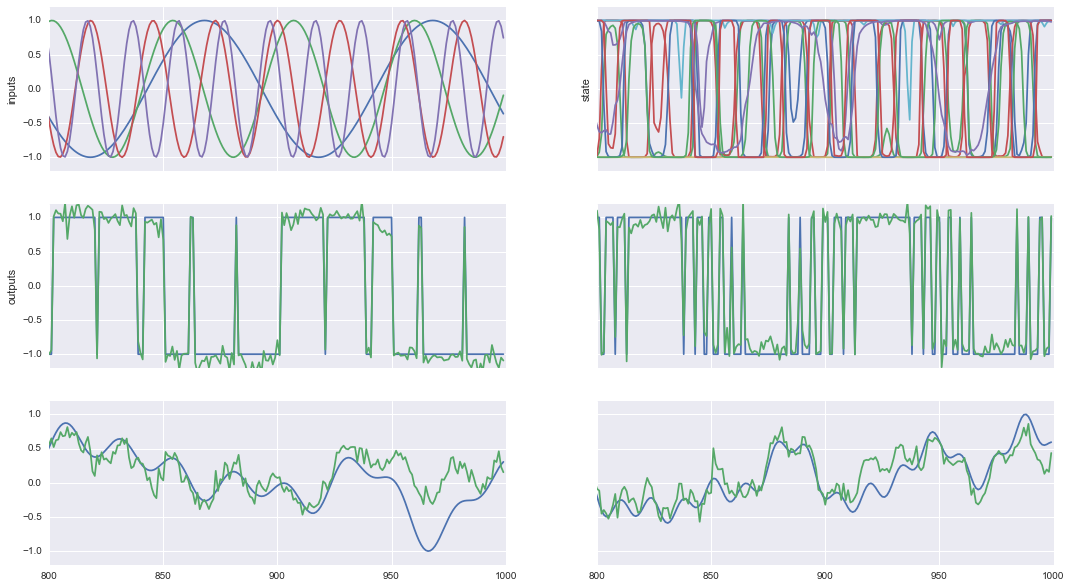

In [261]:
f, ((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3,2,sharex='col',sharey='row', figsize=(18,10),
                                        subplot_kw=dict(xlim=(T-2*cycle,T),
                                                        ylim=(-1.2,1.2)))
# Row 1: inputs; state
ax1.plot(u_data)
ax1.set_ylabel("inputs")
ax2.plot(x_predicted[:,0:10])
ax2.set_ylabel("state")

# Row 2, 3: outputs
ax3.plot(y_data[:,0])
ax3.plot(y_predicted[:,0])
ax3.set_ylabel("outputs")
ax4.plot(y_data[:,1])
ax4.plot(y_predicted[:,1])
ax5.plot(y_data[:,2])
ax5.plot(y_predicted[:,2])
ax6.plot(y_data[:,3])
ax6.plot(y_predicted[:,3])

plt.show()

In [ ]:
y_hat_out = sess.run(y_hat, feed_dict={u: u_batch, y: y_batch})
y_hat_out = np.stack(y_hat_out, axis=0)
y_hat_out = np.reshape(y_hat_out, [num_steps*batch_size, m], order="F")

y_in_plot = np.reshape(y_in, [num_steps*batch_size, m], order="F")
u_in_plot = np.reshape(u_in, [num_steps*batch_size, m], order="F")